# РЕАЛИЗАЦИЯ ТЕХНИКИ BOOTSTRAP ПРИ ВЫБОРЕ РЕГИОНА ДЛЯ РАЗРАБОТКИ НЕФТЯНЫХ СКВАЖИН 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li></ul></li><li><span><a href="#Определение-констант" data-toc-modified-id="Определение-констант-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Определение констант</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Работа-с-дубликатами" data-toc-modified-id="Работа-с-дубликатами-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Работа с дубликатами</a></span></li><li><span><a href="#Проверка-преобразований" data-toc-modified-id="Проверка-преобразований-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Проверка преобразований</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
- в избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- строят модель для предсказания объёма запасов в новых скважинах;
- выбирают скважины с самыми высокими оценками значений;
- определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Данные - синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Описание данных**  
Признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака скважины (неважно, что они означают, но сами признаки значимы).

Целевой признак:
- product — объём запасов скважины, тыс. баррелей.

### Постановка задачи
Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой bootstrap. Выберите регионы с наибольшей средней прибылью, где вероятность убытков меньше 2.5%.

**Важно:** 
- для обучения модели используйте линейную регрессию,
- при разведке региона исследуйте 500 скважин, с помощью машинного обучения выберите из них 200 лучших для разработки,
- бюджет на разработку скважин в регионе — 10 млрд рублей,
- доход от продажи 1000 баррелей нефти составляет 450 тыс рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Определение констант

In [2]:
#Фиксируем: 
# - значение для random_state
SEED = 36741
# - путь к файлам с данными   
PATH = '/datasets/geo_data_*.csv'
# - целевой признак объекта
TARGET = 'product'
# - признаки объекта
FEATURES = ['f0', 'f1', 'f2']
# - количество скважин для исследования
PTS_TO_RESEARCH = 500
# - количество скважин для разработки
PTS_TO_PICK = 200  
# - бюджет на разработку скважин, руб.
BUDGET = 10**10
# - доход от продажи 1000 баррелей, руб.
INCOME_PER_UNIT = 450000

## Загрузка и подготовка данных
### Обзор данных
Поместим данные в DataFrame. На примере нескольких строк оценим датасеты визульно. Посмотрим на общую информацию.

In [3]:
dfs = []
for i in range(0, 3):
    df = pd.read_csv(PATH.replace('*', str(i)))    
    display(df.head(3))    
    df.info()
    dfs.append(df)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Типы данных определены верно, данные интерпретированы корректно. Пропуски отсутствуют. Столбцы именованы в snake_case.

Изучим описательную статистику и распределение данных для нулевого региона:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

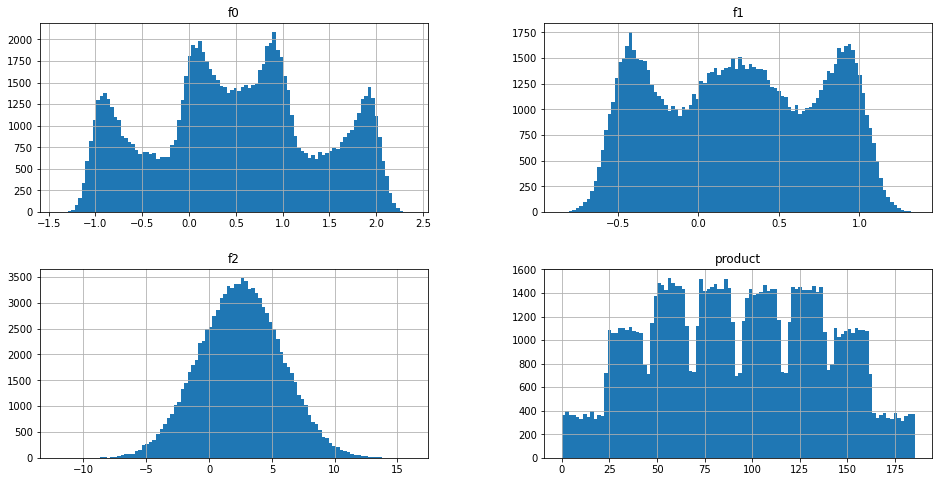

In [4]:
display(dfs[0].describe())
dfs[0].hist(figsize=(16, 8), bins=100)

Первого региона:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

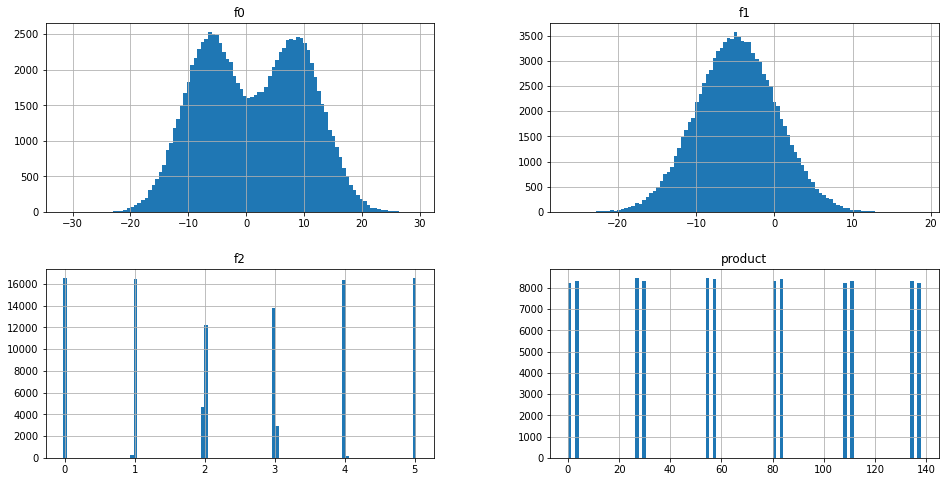

In [5]:
display(dfs[1].describe())
dfs[1].hist(figsize=(16, 8), bins=100)

И второго региона:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

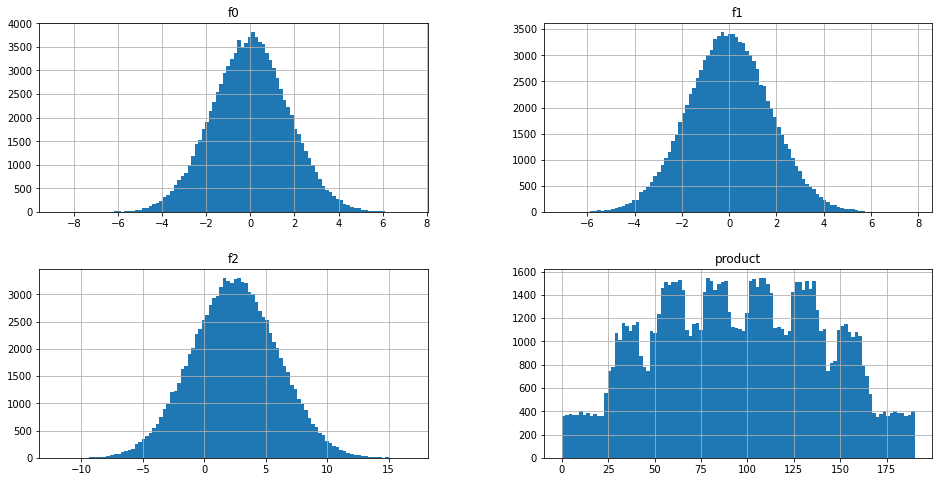

In [6]:
display(dfs[2].describe())
dfs[2].hist(figsize=(16, 8), bins=100)

По условиям задачи, нам неизвестны единицы измерения, реальный диапазон и природа признаков `f0`, `f1` и `f2`. Поэтому сложно сказать что-либо опеределенное, глядя на гистограммы и описательную статистику этих величин. Отметим лишь их различный масштаб. 

Целевой признак `product` в описательной статистике выглядит правдоподобно. На распределениях демонстрирует яркую мультимодальность для всех регионов. При этом в распределении для первого региона, будто бы, оставлены только наиболее частотные значения. Мультимодальность говорит о наличии фактора, который делит скважины на группы по объему запасов. 
### Работа с дубликатами
Поищем явные и неявные дубликаты.

In [7]:
print('Количество явных дубликатов:')
for i in range(0, len(dfs)):
    print(' - датасет {0}: {1}'.format(i, dfs[i].duplicated().sum()))

Количество явных дубликатов:
 - датасет 0: 0
 - датасет 1: 0
 - датасет 2: 0


Явные дубликаты отсутствуют. 

In [8]:
print('Количество неявных дубликатов:')
for i in range(0, len(dfs)):
    print(' - датасет {0}: {1}'.format(i, dfs[i]['id'].duplicated().sum()))

Количество неявных дубликатов:
 - датасет 0: 10
 - датасет 1: 4
 - датасет 2: 4


В столбце `id` каждого датасета содержится несколько неявных дубликатов. Избавимся от всех записей с неявными дубликатами, т.к.:
 - иденификатор скважины, по условиям задачи, уникален,
 - мы не знаем какая из записей с повторяющимся `id` содержит достоверную информацию,  
 - количество записей с дубликатами пренебрежимо мало.

In [9]:
for i in range(0, len(dfs)):
    dfs[i] = dfs[i].drop_duplicates(subset=['id'], keep=False, ignore_index=True)

### Проверка преобразований

In [10]:
for df in dfs:    
    display(df.head(3))    
    df.info()    

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99980 entries, 0 to 99979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Преобразования прошли корректно.
## Обучение и проверка модели
В рамках настоящего исследования нам предстоит решить задачу регрессии. В качестве модели используем `LinearRegression`. Определим признаки. 

In [11]:
print('Признаки объекта:', FEATURES,
      '\nЦелевой признак объекта:', TARGET)

Признаки объекта: ['f0', 'f1', 'f2'] 
Целевой признак объекта: product


In [12]:
productions_true_pred = []
d = {'rmse' : [],
     'production_true_mean' : [],
     'production_pred_mean' : []}
#Для каждого региона
for df in dfs: 
    #формируем обучающую и валидационную выборку
    f_train, f_valid, t_train, t_valid = train_test_split(df[FEATURES], 
                                                          df[TARGET], 
                                                          test_size=0.25, 
                                                          random_state=SEED)
    #масштабируем признаки
    scaler = StandardScaler()    
    f_train = pd.DataFrame(scaler.fit_transform(f_train), columns=FEATURES)
    f_valid = pd.DataFrame(scaler.transform(f_valid), columns=FEATURES)
    #обучаем модель
    model = LinearRegression()
    model.fit(f_train, t_train)
    #делаем предсказания на валидационной выборке
    p_valid = pd.Series(model.predict(f_valid))
    t_valid = t_valid.reset_index(drop=True)
    #сохраняем предсказания и правильные ответы
    productions_true_pred.append(pd.DataFrame({'t_valid' : t_valid,
                                              'p_valid' : p_valid}))
    #сохраняем реальный, предсказанный средний запас сырья и RMSE модели    
    d['production_true_mean'].append(t_valid.mean())
    d['production_pred_mean'].append(p_valid.mean())
    d['rmse'].append(mean_squared_error(t_valid, p_valid, squared=False))
#формируем сводную таблицу по регионам 
metrics = pd.DataFrame(d, index=['region_0', 'region_1', 'region_2'])

Рассмотрим средний запас предсказанного сырья и RMSE моделей по регионам. Выделим регионы с максимальным средним запасом на скважину и минимальной RMSE.

In [13]:
metrics
s = metrics.style
s.highlight_max(subset=['production_true_mean', 'production_pred_mean'], 
                color='lightblue', 
                axis=0)
s.highlight_min(subset=['rmse'], 
                color='lightblue', 
                axis=0)

,rmse,production_true_mean,production_pred_mean
region_0,37.665527,91.965657,92.769087
region_1,0.885462,68.850943,68.854205
region_2,40.066490,95.019674,95.088482


По показателю RMSE нулевой и второй регионы демонстрируют сопоставимые значения: ~38 и ~40 тыс.барр. соответственно. На их фоне первый регион показывает результат на два порядка ниже: менее 1 тыс.барр. Учитывая искусственную природу используемых данных, предположим, что низкая RMSE для первого региона предусмотрена авторами задачи.

Отметим, что реальный и предсказанный средний запас сырья на скважину практически не отличается, несмотря на существенные значения RMSE для нулевого и второго регионов.  

По показателю реального и предсказанного среднего объема сырья на скважину (`production_true_mean`, `production_pred_mean`) лидирует второй регион: ~95 тыс.барр. За ним с небольшой разницей следует нулевой регион: ~92-93 тыс.барр. Первый регион показывает самый низкий результат: ~69 тыс.барр. 

## Подготовка к расчёту прибыли
Рассчитаем средний запас сырья на скважину (тыс.барр.) для безубыточной разработки 200 скважин.

In [14]:
break_even_point = round(BUDGET / INCOME_PER_UNIT / PTS_TO_PICK, 6)
break_even_point

111.111111

С помощью столбчатой диаграммы сравним полученный объём сырья с запасами в каждом регионе.

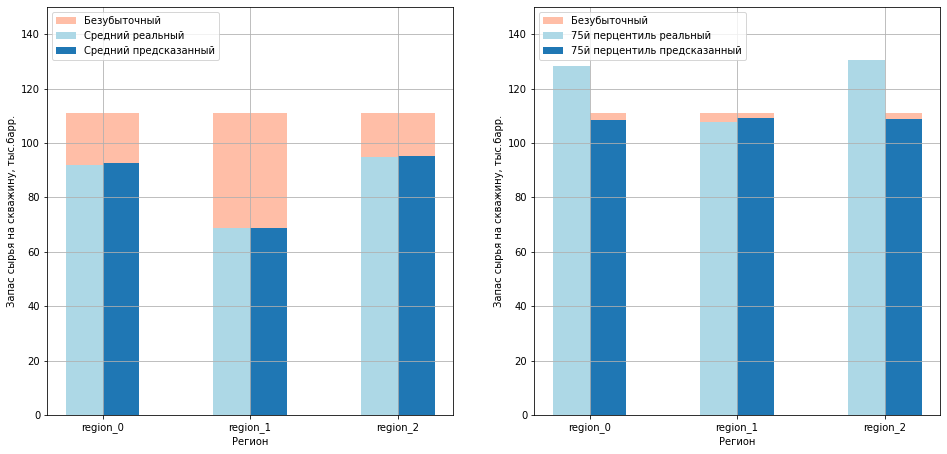

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(16, 7.5))
#строим диаграммы для средних запасаов 
axis[0].bar(metrics.index, 
         np.full(3, break_even_point), 
         width=0.5, 
         align='center', 
         color='coral',         
         alpha=0.5,
         label='Безубыточный')
axis[0].bar(metrics.index, 
         metrics['production_true_mean'], 
         width=-0.25, 
         align='edge', 
         color='lightblue', 
         label='Средний реальный')
axis[0].bar(metrics.index, 
         metrics['production_pred_mean'], 
         width=0.25, 
         align='edge', 
         label='Средний предсказанный')
axis[0].grid(True)
axis[0].set_ylim([0, 150])
axis[0].set_xlabel('Регион')
axis[0].set_ylabel('Запас сырья на скважину, тыс.барр.')
axis[0].legend(loc='upper left')
#строим диаграммы запасаов 75го перцентиля
axis[1].bar(metrics.index, 
         np.full(3, break_even_point), 
         width=0.5, 
         align='center', 
         color='coral',         
         alpha=0.5,
         label='Безубыточный')
axis[1].bar(metrics.index, 
         list(map(lambda p: p['t_valid'].quantile(0.75), productions_true_pred)), 
         width=-0.25, 
         align='edge', 
         color='lightblue', 
         label='75й перцентиль реальный')
axis[1].bar(metrics.index, 
         list(map(lambda p: p['p_valid'].quantile(0.75), productions_true_pred)), 
         width=0.25, 
         align='edge', 
         label='75й перцентиль предсказанный')
axis[1].grid(True)
axis[1].set_ylim([0, 150])
axis[1].set_xlabel('Регион')
axis[1].set_ylabel('Запас сырья на скважину, тыс.барр.')
axis[1].legend(loc='upper left')

fig.show()

Для всех регионов: 
- средний запас сырья на скважину значительно ниже уровня, необходимого для безубыточной разработки 200 скважин,
- 25% скважин (находящиеся за 75м перцентилем) имеют запас близкий или превышающий этот уровень.

## Расчёт прибыли и рисков 

Опишем функцию для расчёта прибыли от 200 скважин, отобранных по предсказаниям модели.

In [16]:
def calc_income(data):
    """Выбирает PTS_TO_PICK скважин с максимальными 
    предсказанными запасами. Возвращает прибыль, 
    рассчитаную по реальным запасам выбранных скважин.
    АРГУМЕНТЫ:
    data -- DataFrame с реальными и предсказанными 
            запасами скважин. 
    """
    product_sum = data.sort_values(by='p_valid')\
                  .tail(PTS_TO_PICK)['t_valid']\
                  .sum()
    return product_sum * INCOME_PER_UNIT - BUDGET 

С помощью техники bootstrap на 1000 выборок рассчитаем для каждого региона: 
 - среднюю прибыль,
 - 95%-й доверительный интервал,
 - вероятность убытков (отрицательной прибыли). 

In [17]:
income_means = []
ci_mins = []
ci_maxs = []
loss_probas = []
rs = np.random.RandomState(SEED)
#Для реальных и предсказанных запасов скважин каждого региона:
for p in productions_true_pred:
    incomes = []    
    for i in range(0, 1000):
        # - выделяем случайную выборку количеством PTS_TO_RESEARCH скважин 
        sample = p.sample(n=PTS_TO_RESEARCH, replace=True, random_state=rs)
        # - рассчитываем и сохраняем прибыль от PTS_TO_PICK самых перспективных скважин из выборки
        incomes.append(calc_income(sample))
    #Для 1000 выборок рассчитываем и сохраняем:
    incomes = pd.Series(incomes)
    # - среднюю прибыль, руб. 
    income_means.append(round(incomes.mean())) 
    # - границы 95% доверительного интервала, руб. 
    ci_mins.append(round(incomes.quantile(0.025)))
    ci_maxs.append(round(incomes.quantile(0.975)))
    # - вероятность убытков, %
    loss_probas.append((incomes < 0).mean() * 100)
#Дополняем сводную таблицу по регионам 
metrics['income_true_mean'] = income_means
metrics['income_true_2.5th'] = ci_mins
metrics['income_true_97.5th'] = ci_maxs
metrics['loss_proba'] = loss_probas

Рассмотрим сводную таблицу показателей по регионам. Выделим регионы с максимальной средней прибылью и минимальным риском.

In [18]:
metrics
s = metrics.style
s.highlight_max(subset=['income_true_mean'], color='lightblue', axis=0)
s.highlight_min(subset=['loss_proba'], color='lightblue', axis=0)

,rmse,production_true_mean,production_pred_mean,income_true_mean,income_true_2.5th,income_true_97.5th,loss_proba
region_0,37.665527,91.965657,92.769087,372033348,-151912718,886751933,8.100000
region_1,0.885462,68.850943,68.854205,426366953,38911566,819491482,1.600000
region_2,40.066490,95.019674,95.088482,368083600,-146499576,844873858,7.700000


С т.з. вероятности убытков условиям задачи соответствует только первый регион. Нулевой и второй регионы показывают вероятность 8.1% и 7.7% соответственно, что значительно выше пороговых 2.5%. Кроме того, первый регион имеет максимальную среднюю прибыль, а 95% доверительный интервал целиком в положительной зоне (> 0). 

На основании изложенного, первый регион является наиболее перспективным для разработки новых скважин.

## Выводы
**В ходе загрузки и подготовки данных:**
 - проведен обзор данных ([см.3.1](#%D0%9E%D0%B1%D0%B7%D0%BE%D1%80-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)), 
 - выявлены и обработаны дубликаты ([см.3.2](#%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0-%D1%81-%D0%B4%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B0%D1%82%D0%B0%D0%BC%D0%B8)).
 
**В ходе обучения и проверки моделей показано следующее** ([см.4](#%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B8-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8)):
 - первый регион демонстрирует минимальную (менее 1 тыс.барр) RMSE,
 - во всех регионах реальный и предсказанный средний запас сырья на скважину практически не отличается,
 - второй регион лидирует по показателю реального и предсказанного среднего объема сырья на скважину.
 
**В ходе подготовки к расчету прибыли показано следующее** ([см.5](#%D0%9F%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0-%D0%BA-%D1%80%D0%B0%D1%81%D1%87%D1%91%D1%82%D1%83-%D0%BF%D1%80%D0%B8%D0%B1%D1%8B%D0%BB%D0%B8)):
 - для всех регионов:
     - средний запас сырья на скважину ниже уровня, необходимого для безубыточной разработки 200 скважин,
     - 25% скважин, имеют запас близкий или превышающий безубыточный уровень.
     
**В ходе расчета прибыли и рисков показано:** первый регион является наиболее перспективным для разработки новых скважин ([см.6](#%D0%A0%D0%B0%D1%81%D1%87%D1%91%D1%82-%D0%BF%D1%80%D0%B8%D0%B1%D1%8B%D0%BB%D0%B8-%D0%B8-%D1%80%D0%B8%D1%81%D0%BA%D0%BE%D0%B2)).